In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

### Configuration

In [2]:
# Model configuration
# Encoder
input_shape = (28, 28, 1)
before_flatten_shape = (7, 7, 64)
enc_layer_nums = 4
enc_filters = [32, 64, 64, 64]
enc_kernel_size = [3, 3, 3, 3]
enc_strides = [1, 2, 2, 1]
enc_padding = ["same"] * enc_layer_nums
latent_dim = 2
# Decoder
dec_layer_nums = 4
dec_filters = [64, 64, 32, 1]
dec_kernel_size = [3, 3, 3, 3]
dec_strides = [1, 2, 2, 1]
dec_padding = ["same"] * dec_layer_nums
# Common
drop_rate = 0.25
model_config = {"input_shape": input_shape,
                "before_flatten_shape": before_flatten_shape,
                "enc_layer_nums": enc_layer_nums,
                "enc_filters": enc_filters,
                "enc_kernel_size": enc_kernel_size,
                "enc_strides": enc_strides,
                "enc_padding": enc_padding,
                "latent_dim": latent_dim,
                "dec_layer_nums": dec_layer_nums,
                "dec_filters": dec_filters,
                "dec_kernel_size": dec_kernel_size,
                "dec_strides": dec_strides,
                "dec_padding": dec_padding,
                "drop_rate": drop_rate}

# Training configuration
kl_loss_factor = 0.00001
learning_rate = 0.001
beta_1 = 0.9
beta_2 = 0.999
batch_size = 32
epochs = 10

### Prepare Dataset

In [3]:
# Load dataset
(x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
print(x_train.shape)

(60000, 28, 28)


In [4]:
# Normalization
x_train = x_train / 255.
print("min: {}, max: {}".format(np.min(x_train), np.max(x_train)))

# Reshape
x_train = x_train.reshape([-1, 28, 28, 1])
print(x_train.shape)

min: 0.0, max: 1.0
(60000, 28, 28, 1)


### Prepare Model

In [5]:
def build_encoder(config):
    # Define input
    inputs = tf.keras.Input(shape=config["input_shape"], name="encoder_input")
    
    # Define layers
    x = inputs
    for i in range(config["enc_layer_nums"]):
        x = tf.keras.layers.Conv2D(filters=config["enc_filters"][i],
                                   kernel_size=config["enc_kernel_size"][i],
                                   strides=config["enc_strides"][i],
                                   padding=config["enc_padding"][i],
                                   name="encoder_conv_{}".format(i + 1))(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU()(x)
        x = tf.keras.layers.Dropout(config["drop_rate"])(x)
    x = tf.keras.layers.Flatten()(x)
    
    # Define output
    mean = tf.keras.layers.Dense(config["latent_dim"], name="mean")(x)
    log_var = tf.keras.layers.Dense(config["latent_dim"], name="log_var")(x)
    return tf.keras.Model(inputs=inputs, outputs=[mean, log_var], name="encoder")

def build_decoder(config):
    # Define input
    inputs = tf.keras.Input(shape=config["latent_dim"], name="decoder_input")
    
    # Define layers
    x = inputs
    x = tf.keras.layers.Dense(np.prod(config["before_flatten_shape"]))(x)
    x = tf.keras.layers.Reshape(config["before_flatten_shape"])(x)
    for i in range(config["dec_layer_nums"]):
        x = tf.keras.layers.Conv2DTranspose(filters=config["dec_filters"][i],
                                            kernel_size=config["dec_kernel_size"][i],
                                            strides=config["dec_strides"][i],
                                            padding=config["dec_padding"][i],
                                            name="decoder_conv_t_{}".format(i + 1))(x)
        if i < config["dec_layer_nums"] - 1:
            x = tf.keras.layers.LeakyReLU()(x)
        else:
            x = tf.keras.layers.Activation("sigmoid")(x)
    
    # Define output
    outputs = x
    return tf.keras.Model(inputs=inputs, outputs=outputs, name="decoder")

def sampling(mean, log_var):
    epsilon = tf.random.normal(tf.shape(mean), mean=0.0, stddev=1.0)
    return mean + tf.math.exp(log_var / 2) * epsilon

class Autoencoder(tf.keras.Model):
    def __init__(self, config):
        super().__init__(self)
        self.encoder = build_encoder(config)
        self.decoder = build_decoder(config)
        self.mean = None
        self.log_var = None
        
    def call(self, x, training=False):
        self.mean, self.log_var = self.encoder(x)
        latent_vector = sampling(self.mean, self.log_var)
        outputs = self.decoder(latent_vector)
        return outputs

In [6]:
# Build Autoencoder model
model = Autoencoder(model_config)
model.build(input_shape=(batch_size, 28, 28, 1))

### Define loss function

In [7]:
class VAELoss(tf.keras.losses.Loss):
    def __init__(self, model, kl_loss_factor):
        super().__init__()
        self.model = model
        self.kl_loss_factor = kl_loss_factor
        self.r_loss = tf.keras.losses.MeanSquaredError()
        
    def kl_loss(self):
        mean = self.model.mean
        log_var = self.model.log_var
        return -0.5 * tf.reduce_sum(1 + log_var - tf.math.square(mean) - tf.math.exp(log_var), axis=1)
        
    def call(self, y_true, y_pred):
        r_loss = self.r_loss(y_true, y_pred)
        kl_loss = self.kl_loss() * kl_loss_factor
        return r_loss + kl_loss

### Train Model

In [8]:
# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2),
              loss=VAELoss(model=model, kl_loss_factor=kl_loss_factor))

# Fit model
model.fit(x_train, x_train,
          batch_size=batch_size,
          epochs=epochs,
          shuffle=True)

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 114s 2ms/sample - loss: 0.0529
Epoch 2/10
60000/60000 [==============================] - 104s 2ms/sample - loss: 0.0476
Epoch 3/10
60000/60000 [==============================] - 105s 2ms/sample - loss: 0.0463
Epoch 4/10
60000/60000 [==============================] - 106s 2ms/sample - loss: 0.0454
Epoch 5/10
60000/60000 [==============================] - 109s 2ms/sample - loss: 0.0449
Epoch 6/10
60000/60000 [==============================] - 111s 2ms/sample - loss: 0.0446
Epoch 7/10
60000/60000 [==============================] - 111s 2ms/sample - loss: 0.0442
Epoch 8/10
60000/60000 [==============================] - 110s 2ms/sample - loss: 0.0440
Epoch 9/10
60000/60000 [==============================] - 111s 2ms/sample - loss: 0.0438
Epoch 10/10
60000/60000 [==============================] - 110s 2ms/sample - loss: 0.0437


In [ ]:
model.save_weights("./save/model")

### Analysis

In [ ]:
model.load_weights("./save/model")

In [9]:
def get_latent_space(model, x_train, batch_size=32):
    # Calculate batch_nums
    batch_nums = (x_train.shape[0] // batch_size) + (x_train.shape[0] % batch_size != 0)
    
    latent_vectors = []
    for i in range(batch_nums):
        # Get x_batch
        x_batch = x_train[i * batch_size:(i + 1) * batch_size].astype(np.float32)
        # Get latent_vector
        mean, log_var = model.encoder.predict(x_batch)
        latent_vector = sampling(mean, log_var)
        latent_vectors.extend(latent_vector)
    return np.asarray(latent_vectors)

In [10]:
latent_vectors = get_latent_space(model, x_train, batch_size=batch_size)

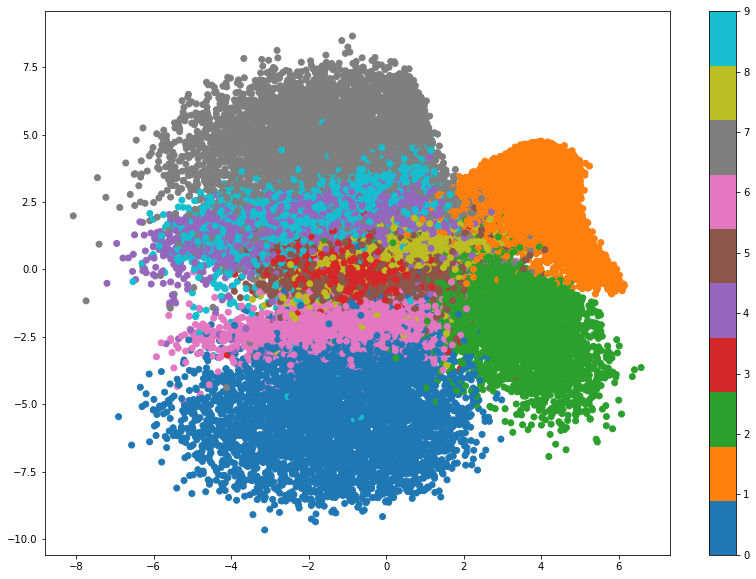

In [11]:
plt.figure(figsize=(14, 10))
plt.scatter(latent_vectors[:, 0], latent_vectors[:, 1], c=y_train, cmap="tab10")
plt.colorbar()
plt.show()